# Macroprudential Policy and the Housing Market
This notebook solves and simulates the Heterogenous Agent Housing Market (HAH) model and produces the output contained in my Master's thesis. 

**Dependencies:**

The code structure builds upon the framework developed by Jeppe Druedahl & Co. in the [NumEconCopenhagen Project](https://github.com/NumEconCopenhagen)

Packages required for running the notebook are:
- [ConSav](https://pypi.org/project/ConSav/)
- [EconModel](https://pypi.org/project/EconModel/)
- [matplotlib](https://pypi.org/project/matplotlib/)
- [numpy](https://pypi.org/project/numpy/)
- [numba](https://pypi.org/project/numba/)
- [pandas](https://pypi.org/project/pandas/)

## 0 Prerequisites

### 0.0 Import packages and ModelClass

In [1]:
%load_ext autoreload
%autoreload 2

# standard packages
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd

nb.set_num_threads(4) # set equal to the number of cores in your CPU

# local modules
import figs
import analyse as ana
import validate
from HAHModel import HAHModelClass

### 0.1 Import data for equivalence scale and life cycle income profile

In [31]:
# read data
data = pd.read_excel(
    io='equiscale.xlsx',
    sheet_name='output')

# adjust income profile and slice
Tr = 65-25 # retirement age - par.Tmin
pension = 0.75 # adjustment for drop in income at retirement

data['chi'] = data['chi'].interpolate(method='linear')+0.1 # quick fix to get mean ca. one
data = data.iloc[3:-3,:]
data['chi'].iloc[Tr:] = pension*np.mean(data['chi'].iloc[Tr:])

# extract arrays
n = data['n'].to_numpy(dtype='float')
chi = data['chi'].to_numpy(dtype='float') 

## 1 Baseline model

In [32]:
# initialise an instance of baseline model
model_baseline = HAHModelClass(
    name='baseline',
    par={ #  
        'beta':0.958, # tradeoff between fitting mortgage debt (~0.95) and net wealth (~0.964)
        'zeta':10, # increased utility cost of default, does it matter?
        'kappa':0.09, # restricted model of KovacsMoran2022
        'nu':0.3,
        'alpha':1.25, # seems necessary with higher alpha to bump up homeowner share
        'phi':0.80, # 0.85 in KovacsMoran2022
        'thetab':170, # 250
        'K':9.0,  #  K= 10 matches homeowneship rate well but debt is too low. K = 8.8 in the nodeduct model
        'C_buy':0.0,   # JEJA sets the buyer cost to zero 
        'chi':chi,
        'n':n,
        'Nd':10,
        'Nm':15,
        'Nx':20,
        'Na':15
        })

model_baseline.precompile_numba() # solve model with very coarse grids --> speed gains
model_baseline.solve()
model_baseline.simulate()
#model_baseline.save()

In [4]:
# simulate the model forward to reach stable bequest distribution
import steady_state
np.random.seed(1995)
par = model_baseline.par
sim = model_baseline.sim
draws1 = np.random.uniform(size=par.simN)
draws2 = np.random.uniform(size=(par.T*par.simN))
draws3 = np.random.lognormal(mean=par.mu_a0,sigma=par.sigma_a0,size=par.simN) # fixed draws for all models
assert np.all(np.isclose(sim.a0,draws3)), 'fixed draws are not equal to initial wealth'
ini_wealth_scale = steady_state.bequest_loop(model_baseline,draws3,bequest_guess=1.09,step_size=0.99) # 1.222201

iteration = 1, discrepancy in means = -0.027682
iteration = 2, discrepancy in means = -0.019549
iteration = 3, discrepancy in means = -0.013823
iteration = 4, discrepancy in means = -0.009799
iteration = 5, discrepancy in means = -0.006893
iteration = 6, discrepancy in means = -0.004884
iteration = 7, discrepancy in means = -0.003438
iteration = 8, discrepancy in means = -0.002438
iteration = 9, discrepancy in means = -0.001715
iteration = 10, discrepancy in means = -0.001207
iteration = 11, discrepancy in means = -0.000855
iteration = 12, discrepancy in means = -0.000604
iteration = 13, discrepancy in means = -0.000427
iteration = 14, discrepancy in means = -0.000296
iteration = 15, discrepancy in means = -0.000210
iteration = 16, discrepancy in means = -0.000148
iteration = 17, discrepancy in means = -0.000102
iteration = 18, discrepancy in means = -0.000072
iteration = 19, discrepancy in means = -0.000049
iteration = 20, discrepancy in means = -0.000035
iteration = 21, discrepancy i

#### save baseline utility for later use

In [5]:
from simulate import calc_utility
from EconModel import jit

with jit(model_baseline) as model:
    calc_utility(model.sim,model.par)

    assert len(np.unique(model_baseline.sim.utility)) == par.simN, 'utility is not unique'
    assert np.sum(np.isinf(model_baseline.sim.utility)) == 0, 'there are individuals with negative infinite utility'

    np.save('output/baseline_utility.npy',model.sim.utility)

### 1.0 Decision Functions

In [56]:
#figs.decision_functions(model_baseline)

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

### 1.1 Life Cycle Behaviour

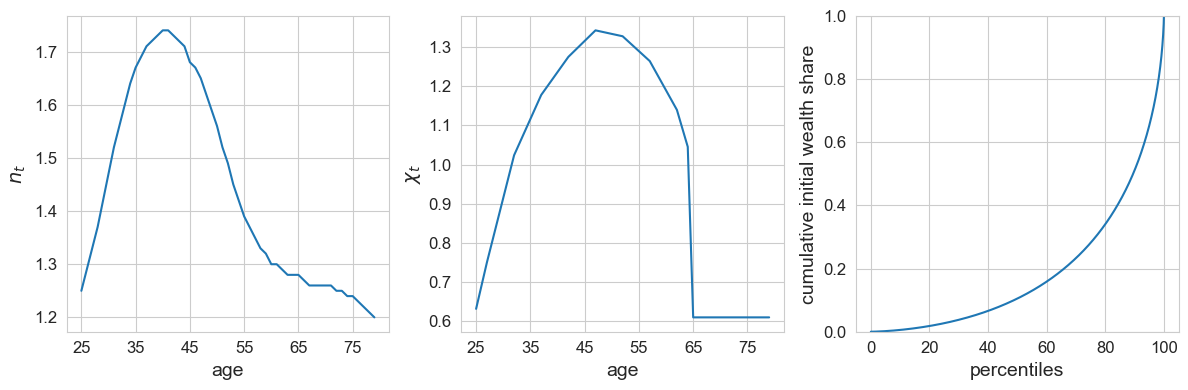

In [6]:
# plot calibration inputs
figs.n_chi_iniwealth(model_baseline,data)

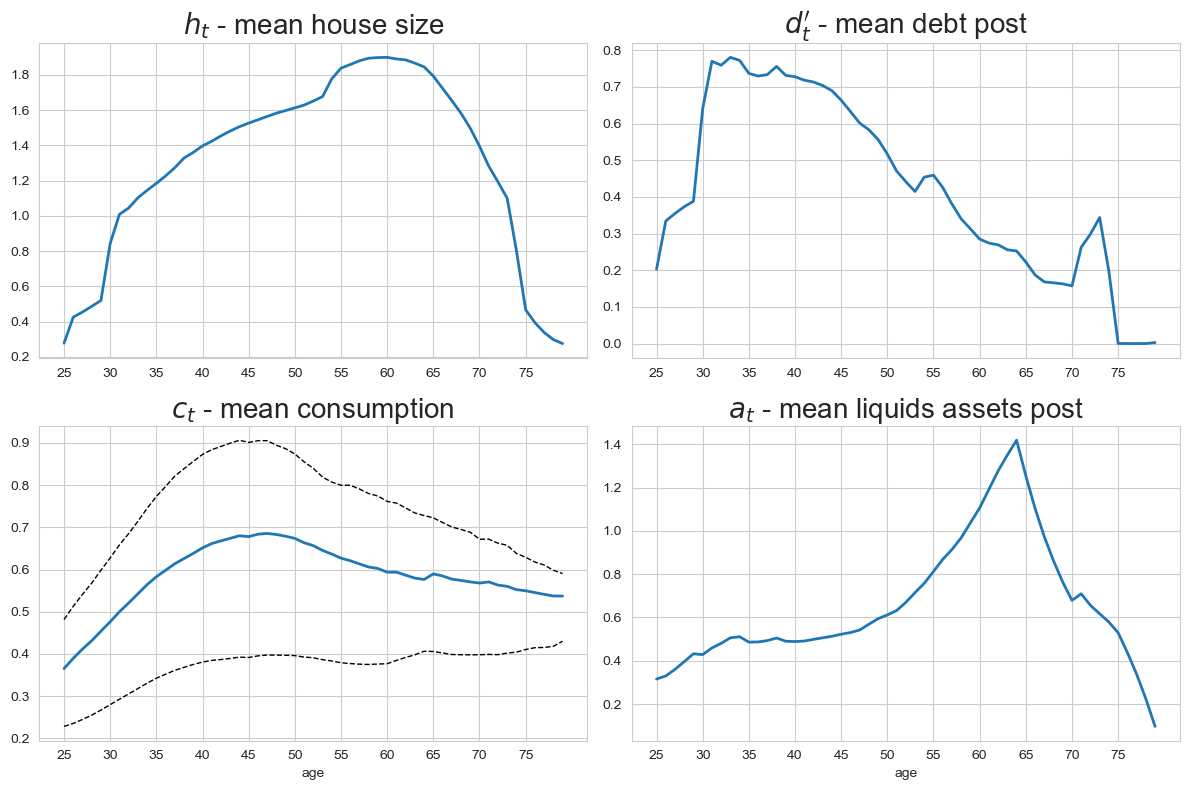

In [7]:
# average behaviour over the life cycle
figs.lifecycle_full(model_baseline)

### 1.2 Life Cycle Behaviour - Model vs. Data

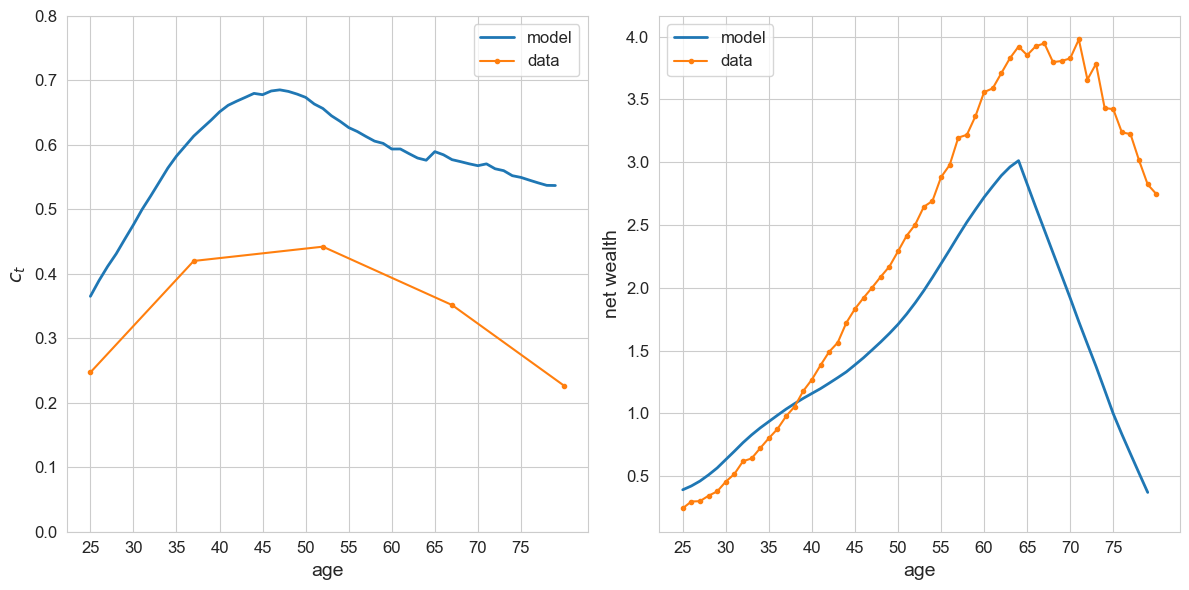

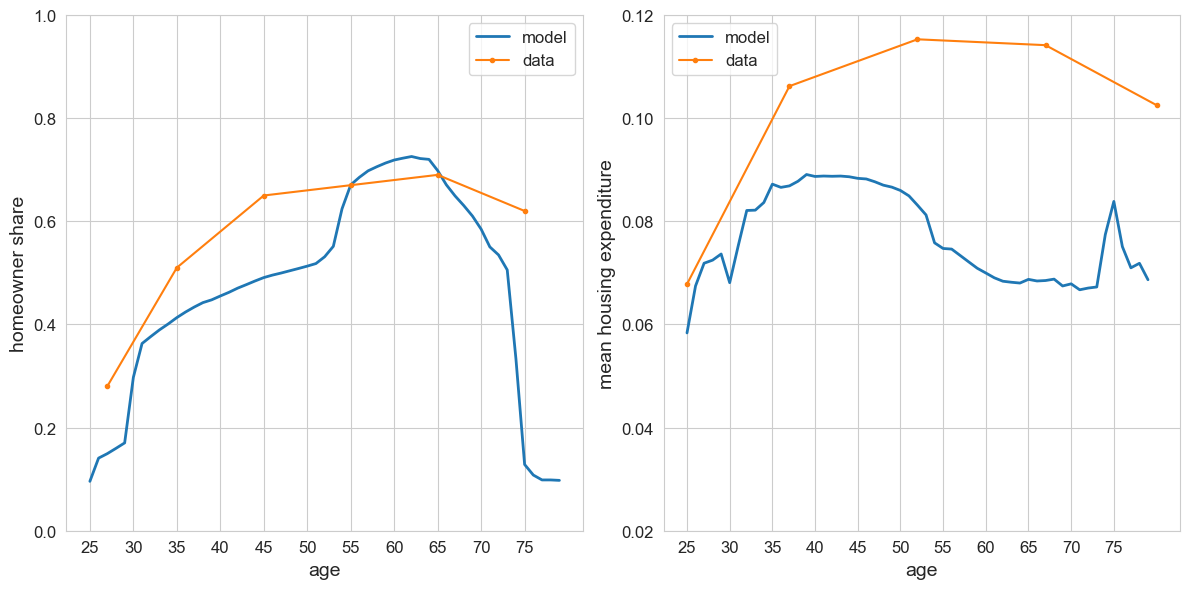

/Users/Christian/Dropbox/KU - Polit/KA/Thesis/MScThesis-2022/figs.py:384: RuntimeWarning: invalid value encountered in true_divide
  DA_shares = np.sum(b_dp_da,axis=1)/np.sum(bool_dp,axis=1)


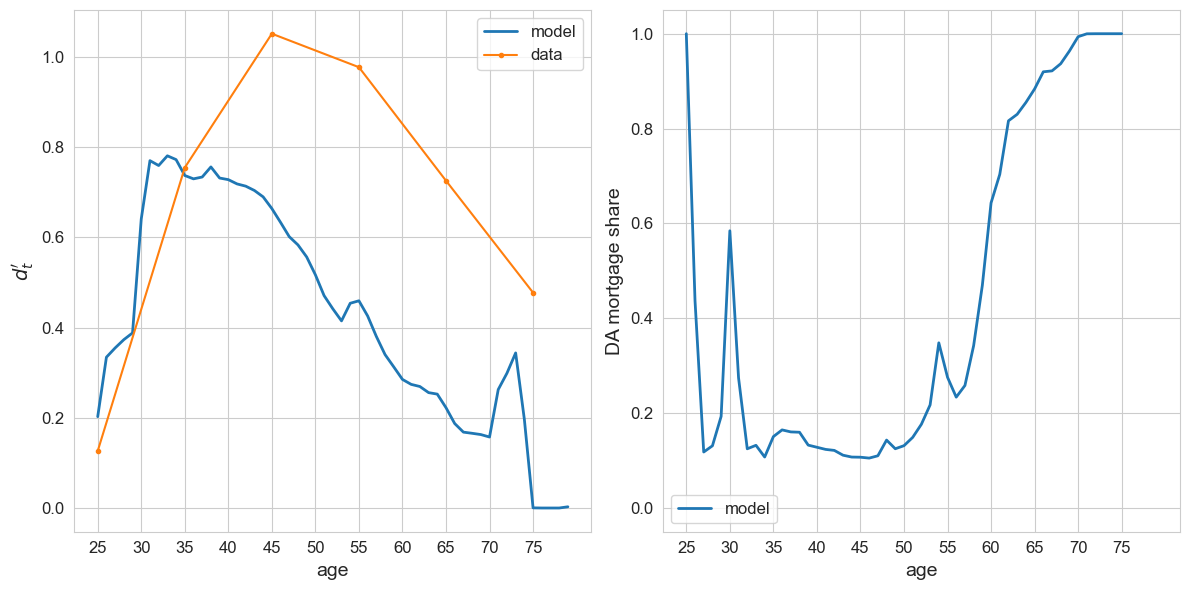

In [8]:
figs.lifecycle_consav(model_baseline)
figs.lifecycle_housing(model_baseline)
figs.lifecycle_mortgage(model_baseline)

In [11]:
sim = model_baseline.sim
print(np.mean(sim.d_prime,axis=1).round(2))

[0.2  0.33 0.35 0.37 0.39 0.64 0.77 0.76 0.78 0.77 0.74 0.73 0.73 0.76
 0.73 0.73 0.72 0.71 0.7  0.69 0.66 0.63 0.6  0.58 0.56 0.52 0.47 0.44
 0.41 0.45 0.46 0.43 0.38 0.34 0.31 0.29 0.27 0.27 0.26 0.25 0.22 0.19
 0.17 0.17 0.16 0.16 0.26 0.3  0.34 0.2  0.   0.   0.   0.   0.  ]


### 1.3 Validate simulation

In [12]:
validate.val_sim(model_baseline)
print()
validate.val_finreg(model_baseline)
print()
validate.val_inc_calib_targets(model_baseline)


there are 0 cases of negative consumption
there is no uncollateralised debt in the simulation
there are no instances of neither buying nor renting
there are no errors in the housing stock

mean interest deduction is 0.013563
average mortgage size at origination is 2.0305
the distribution of DA periods is:
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[4978849  408585   15860   12816   11768   14085   15868   18104   18855
    3177    2033]
the share of DA mortgages at origination is 1.0000
mean LTV is 0.7097 and mean DTI is 1.2015 at mortgage origination

taxes to labour income is 0.3491
median pre tax income is 0.6097
mean property tax is 0.0127
mean pre tax income is 1.0058


### 1.4 Aggregate moments 

In [13]:
# targeted model moments
names_targ, moments_targ = ana.model_moments_targ(model_baseline)
print('Targeted moments from baseline model:')
for i in range(len(names_targ)):
    print(f'  {names_targ[i]} = {moments_targ[i]:.4f}')

Targeted moments from baseline model:
  Aggregate net worth / (annual) labour income = 1.5255
  Annual fraction of houses sold = 0.0513
  Home ownership rate of <35 y.o. = 0.2543
  Mean NW at age 75 / mean NW at age 55 = 0.4546
  Share of households leaving no bequest = 0.4724
  Taxes to labour income = 0.3491


In [14]:
# untargeted model moments
names, moments = ana.model_moments(model_baseline)
print('Untargeted moments from baseline model:')
for i in range(len(names)):
    print(f'  {names[i]} = {moments[i]:.4f}')

Untargeted moments from baseline model:
  Homeowner share = 0.4667
  Mean house size = 2.7921
  Average housing expenditure = 0.0769
  Mean mortgage size = 1.5750
  Share of homeowners with mortgage = 0.5783
  DA mortgage share = 0.3510
  Average LTV ratio = 0.6838
  Average DTI ratio = 1.2605
  Gini wealth coefficient = 0.6746


### 1.5 Who benefits from interest deductions?

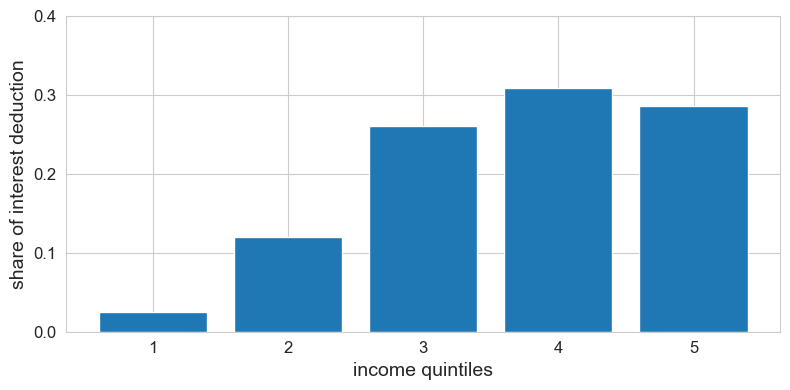

In [15]:
# create bar chart of relative interest deduction by income quintile
figs.deduction_by_income(model_baseline)

### 1.5 Discrete choices over the lifecycle

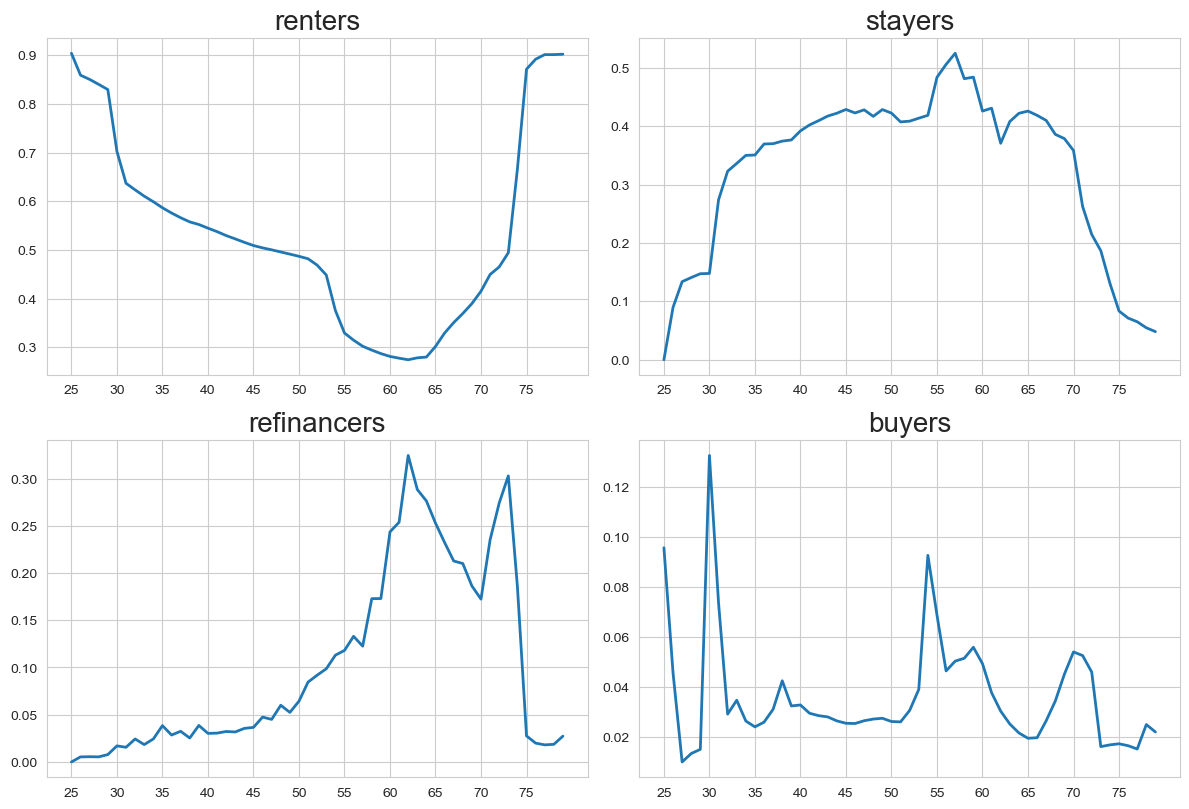

In [16]:
figs.homeownership(model_baseline)

### 1.6 Inspect the life cycle profile of a given household

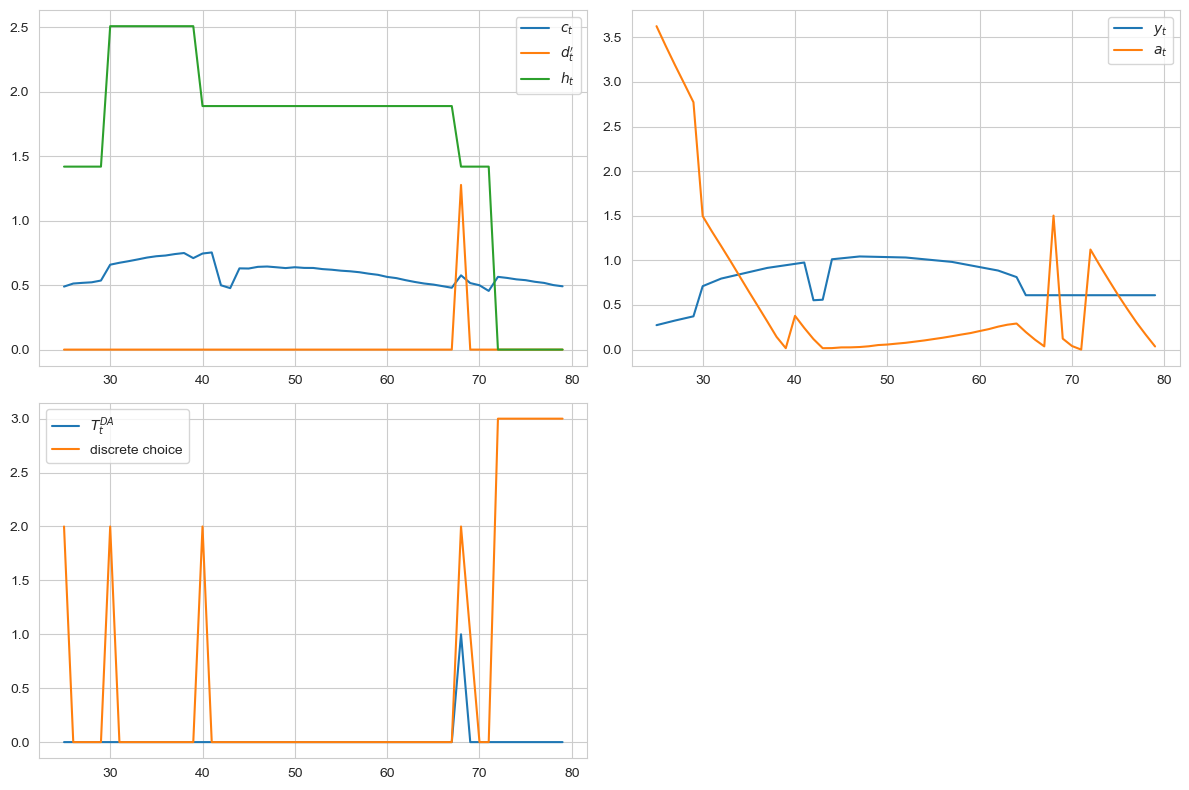

In [14]:
figs.example_household(model_baseline,hh_no=5_000)

## 2 Model without interest rate deduction - no change in house price

### Restart the kernel here! (otherwise computer runs out of disk space...)

#### imports and data

In [ ]:
%load_ext autoreload
%autoreload 2

# standard packages
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd

nb.set_num_threads(4) # set equal to the number of cores in your CPU

# local modules
import figs
import analyse as ana
import validate
from HAHModel import HAHModelClass

In [ ]:
# read data
data = pd.read_excel(
    io='equiscale.xlsx',
    sheet_name='output')

# adjust income profile and slice
Tr = 65-25 # retirement age - par.Tmin
pension = 0.75 # adjustment for drop in income at retirement

data['chi'] = data['chi'].interpolate(method='linear')+0.1 # quick fix to get mean ca. one
data = data.iloc[3:-3,:]
data['chi'].iloc[Tr:] = pension*np.mean(data['chi'].iloc[Tr:])

# extract arrays
n = data['n'].to_numpy(dtype='float')
chi = data['chi'].to_numpy(dtype='float') 

In [18]:
# initialise an instance of baseline model
model_nodeduct_q1 = HAHModelClass(
    name='nodeduct_q1',
    par={
        'beta':0.958, # tradeoff between fitting mortgage debt (~0.95) and net wealth (~0.964)
        'zeta':10, # increased utility cost of default, does it matter?
        'kappa':0.09, # restricted model of KovacsMoran2022
        'nu':0.3,
        #'alpha':1.3, # seems necessary with higher alpha to bump up homeowner share
        #'phi':0.82, # 0.85 in KovacsMoran2022
        'thetab':170, # 250
        'K':9.0,  #  K = 10 matches homeowneship rate well but debt is too low.
        'C_buy':0.0,   # JEJA sets the buyer cost to zero 
        'chi':chi,
        'n':n,
        'Nd':10,
        'Nm':15,
        'Nx':20,
        'Na':15,
        'tau_r0':0.0,
        'tau_r1':0.0
        })

model_nodeduct_q1.precompile_numba() # solve model with very coarse grids --> speed gains
model_nodeduct_q1.solve()
model_nodeduct_q1.simulate(ini_wealth_scale=ini_wealth_scale) # same initial wealth as baseline model after matching

 t = 3 solved in 56.5 secs
 t = 2 solved in 55.9 secs
 t = 1 solved in 0.0 secs
 t = 0 solved in 0.0 secs
 total precomputation time  = 68.7 secs
 total stay-time  = 8.4 secs
 total ref-time   = 11.0 secs
 total buy-time   = 12.4 secs
 total rent-time   = 11.9 secs
 full model solved in = 112.4 secs
model simulated in 56.3 secs
numba precompiled in 173.1 secs
 last period bequest computed in 0.0 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 54 solved in 0.1 secs
 v_bar and q computed in 0.9 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 53 solved in 1.0 secs
 v_bar and q computed in 1.4 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 52 solved in 1.6 secs
 v_bar and q computed

In [19]:
validate.val_sim(model_nodeduct_q1)
print()
validate.val_finreg(model_nodeduct_q1)

there are 0 cases of negative consumption
there is no uncollateralised debt in the simulation
there are no instances of neither buying nor renting
there are no errors in the housing stock

mean interest deduction is 0.000000
average mortgage size at origination is 1.8138
the distribution of DA periods is:
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[5262744  171769    7755    8372    9038    9850   10380   13421    3347
    1600    1724]
the share of DA mortgages at origination is 1.0000
mean LTV is 0.6055 and mean DTI is 0.9070 at mortgage origination


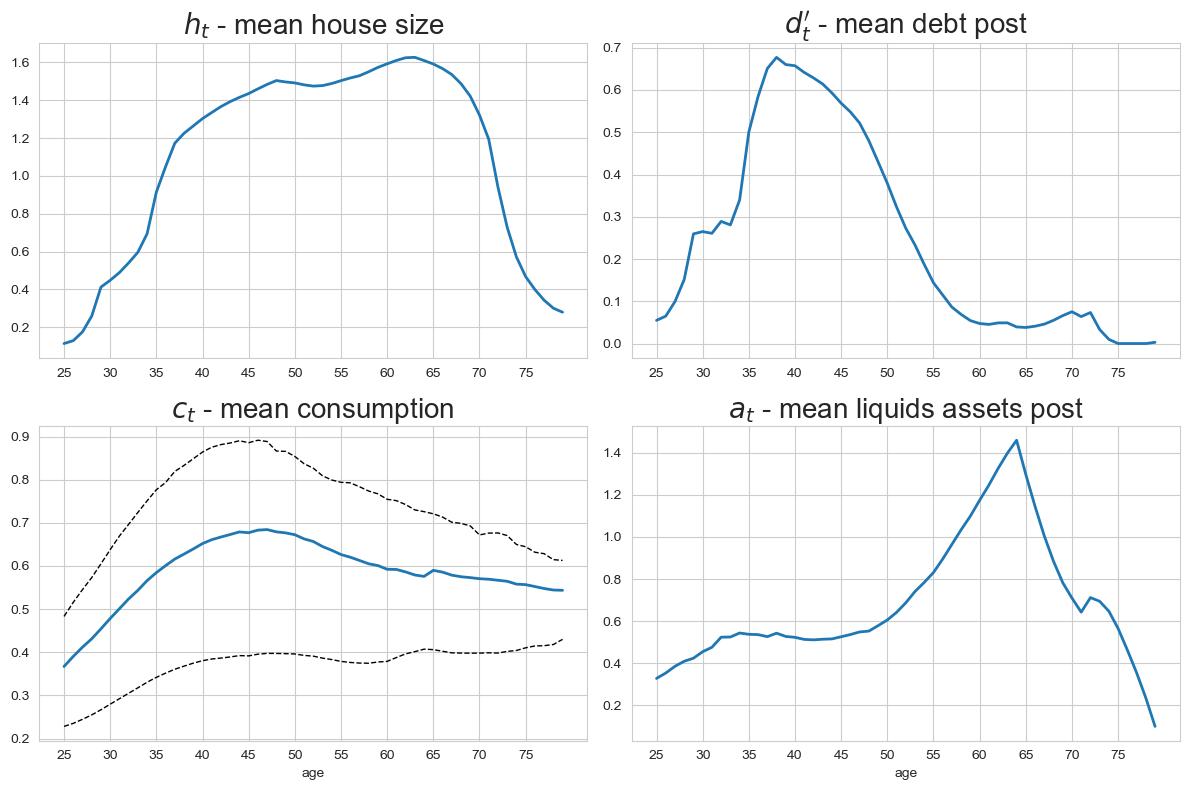

In [20]:
figs.lifecycle_full(model_nodeduct_q1)

### 2.0 Aggregate moments in alternative model

In [21]:
names_targ_nd, moments_targ_nd = ana.model_moments_targ(model_nodeduct_q1)
print('Targeted moments from baseline model without interest rate deductibility:')
for i in range(len(names_targ_nd)):
    print(f'  {names_targ_nd[i]} = {moments_targ_nd[i]:.4f}')

Targeted moments from baseline model without interest rate deductibility:
  Aggregate net worth / (annual) labour income = 1.5382
  Annual fraction of houses sold = 0.0396
  Home ownership rate of <35 y.o. = 0.1284
  Mean NW at age 75 / mean NW at age 55 = 0.4714
  Share of households leaving no bequest = 0.4406
  Taxes to labour income = 0.3509


In [22]:
names_nd, moments_nd = ana.model_moments(model_nodeduct_q1)
print('Untargeted moments from baseline model without interest rate deductibility:')
for i in range(len(names_nd)):
    print(f'  {names_nd[i]} = {moments_nd[i]:.4f}')

Untargeted moments from baseline model without interest rate deductibility:
  Homeowner share = 0.3639
  Mean house size = 3.0476
  Average housing expenditure = 0.0765
  Mean mortgage size = 1.6303
  Share of homeowners with mortgage = 0.4112
  DA mortgage share = 0.2881
  Average LTV ratio = 0.6111
  Average DTI ratio = 1.0800
  Gini wealth coefficient = 0.6789


### 2.1 Consumption equivalent variation between baseline and alternative

In [26]:
N = 1_000
cev_container = np.zeros(N)
u_baseline = np.load('output/baseline_utility.npy')

#with jit (model_nodeduct_q1) as model:
#    u_nodeduct = calc_utility(model.sim,model.par)
#
#u_nodeduct

In [27]:
for n in range(N):
    root = ana.find_cev_direct(u_baseline,model_nodeduct_q1,n,do_print=False)
    cev_container[n] = (root-1)*100

#print(u_baseline[0:100])
#print(u_nodeduct[0:100])

mean ex ante CEV = 0.35 pct.
median ex ante CEV = 0.06 pct.
0.66


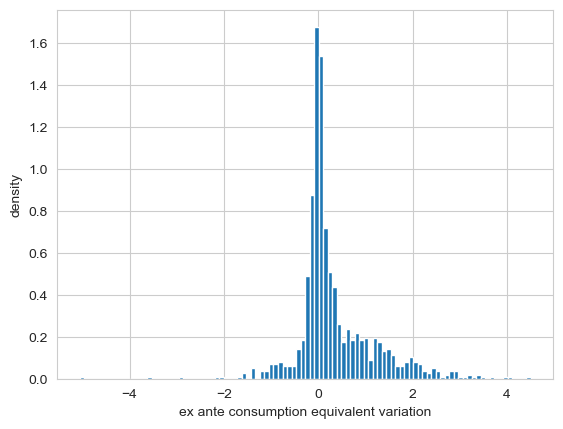

In [30]:
plt.hist(cev_container,bins=100,density=True,stacked=True)
plt.xlabel('ex ante consumption equivalent variation')
plt.ylabel('density');
print(f'mean ex ante CEV = {np.mean(cev_container):.2f} pct.')
print(f'median ex ante CEV = {np.median(cev_container):.2f} pct.')
print(np.sum(cev_container>0)/N)

## Debugging tools

### Test solving the household problem for a few periods

In [ ]:
import HHproblems as hhp
from EconModel import jit

par = model_baseline.par

t = par.T-1
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

with jit(model_baseline) as model: 
    sol = model.sol
    par = model.par
    hhp.last_period_v_bar_q(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')
    t = t-1
    print(f'start solving t={t}')
    #hhp.postdecision_compute_v_bar_q.py_func(t,sol,par)
    hhp.postdecision_compute_v_bar_q_rent(t,sol,par)
    hhp.postdecision_compute_v_bar_q_own(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance fast is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy fast is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')

### Sanity checks

In [ ]:
# check NaNs in relevant part of sol.inv_v_bar

#nan_mat_v = np.argwhere(np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]))
#print(f'size of q at t={t} is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_v.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_v}')
#
## check zero or negative entries in relevant part of sol.inv_v_bar
#zero_mat_v= np.argwhere(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
#print(f'size of c_endo at t={t} with Tda in 0,1,2 is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {zero_mat_v.shape[0]} zero or negative entries')
#print(f'the zero indices/negative are {zero_mat_v}')

par = model_baseline.par
sol = model_baseline.sol

t = 21
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

#nan_mat_q = np.argwhere(np.isnan(sol.q[t,6,0:3,0:Td_len,0:Tda_len,4:,:]))
#print(f'size of q at t={t} is {sol.q[t,6,0:3,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_q.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_q}')

# check zero or negative entries in relevant part of sol.inv_v_bar
zero_mat_q= np.argwhere(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
print(f'size of q at t={t} is {sol.q[t,6,0:3,0:Td_len,0:Tda_len,4:,9].size}')
print(f'there are {zero_mat_q.shape[0]} zero or negative entries')
print(f'the zero indices/negative are {zero_mat_q}')
